# Image classification of cardiomyocyte tissues

This pipeline classifies cardiomyocyte images to distinguish issues from patients with chronic heart failure from ones from health donnors. It builds an image classifier using a `tf.keras.Sequential` model and load data using `tf.keras.preprocessing.image.ImageDataGenerator`. The images downloaded from https://idr.openmicroscopy.org/webclient/?show=project-402 processed with the following:

* Building _data input pipelines_ using the `tf.keras.preprocessing.image.ImageDataGenerator` class to efficiently work with data on disk to use with the model.
* _Overfitting_ —How to identify and prevent it.
* _Data augmentation_ and _dropout_ —Key techniques to fight overfitting in computer vision tasks to incorporate into the data pipeline and image classifier model.

This pipeline follows a basic machine learning workflow:

1. Examine and understand data
2. Build an input pipeline
3. Build the model
4. Train the model
5. Test the model
6. Improve the model and repeat the process

## Import packages

It is always a good idea to import packages separately to minimise their impact on compatibility.

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

Import Tensorflow and the Keras classes needed to construct our model.

In [2]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.python.lib.io import file_io

from PIL import Image

## Load data

Download the dataset idr0042 with the OMERO 5.6.1 JSON API https://docs.openmicroscopy.org/omero/5.6.1/developers/json-api.html. The dataset is stored in the "/tmp/" directory for training and verification.

In [4]:
home_dir = os.environ['HOME']
base_dir = os.path.join(home_dir, 'data-vol-1')

In [5]:
######################################################################################################################
# Download the CSV generated by AutoML where images are sorted into TRAIN, VALIDATION and TEST randomly at 80%:10%:10%
# Comment out to save time. Both file_io and gfile fail with local cache.
######################################################################################################################
# csv_file = os.path.join(base_dir, 'kubeflow/notebooks/idr0042.csv')

# os.system("mkdir -p " + base_dir)
# file_io.copy(oldpath='gs://idr0042/export_data-idr0042-2020-05-06T00:09:20.026Z/image_classification_1.csv', newpath=csv_file, overwrite=True)
# # gfile.copy(src='gs://idr0042/export_data-idr0042-2020-05-06T00:09:20.026Z/image_classification_1.csv', dst=csv_file)

# with open(csv_file, 'r') as f:
#     lines = f.readlines()
#     for line in lines:
#         tokens = line.split(',')
#         dataset_name = tokens[0].lower()
#         source = tokens[1]
#         label_name = tokens[2].strip('\n')
#         fname = source.split('/')[-1]

#         os.system("mkdir -p " + os.path.join(base_dir, dataset_name, label_name))
#         file_io.copy(oldpath=source, newpath=os.path.join(base_dir, dataset_name, label_name, fname), overwrite=True)
#         # gfile.copy(src=source, dst=target_file)
#         print(line)

In [6]:
########################################################
# crop every image into 4 tiles in the original category
# This is to increase the number of images for learning
########################################################
tile_dir = os.path.join(base_dir, 'tiles')

# for root, dirs, files in os.walk(base_dir):
#     if root.startswith(os.path.join(base_dir, 'test')) or root.startswith(os.path.join(base_dir, 'validation')) or root.startswith(os.path.join(base_dir, 'train')):
#         output_dir = root.replace(base_dir, tile_dir)
#         os.system("mkdir -p " + output_dir)
    
#         for filename in files:
#             input_file = os.path.join(root, filename)
#             print(input_file)
            
#             img = Image.open(input_file)
#             img_width, img_hight = img.size

#             # crop into 4 tiles
#             hight = img_hight // 2
#             width = img_width // 2

#             for i in range(2):
#                 for j in range (2):
#                     box = (j*width, i*hight, (j+1)*width, (i+1)*hight)
#                     output_file = os.path.join(output_dir, filename.replace('.png','_x{}_y{}.png'.format(i, j)))
#                     print(output_file)
#                     img.crop(box).save(output_file)

In [7]:
# ################################
# # Create a session to access IDR
# ################################
# import requests


# def get_session() -> requests.Session:
#     IDR_BASE_URL = "https://idr.openmicroscopy.org"
#     INDEX_PAGE = "%s/webclient/?experimenter=-1" % IDR_BASE_URL

#     # create http session
#     with requests.Session() as session:
#         request = requests.Request('GET', INDEX_PAGE)
#         prepped = session.prepare_request(request)
#         response = session.send(prepped)
#         if response.status_code != 200:
#             response.raise_for_status()
#     return session

In [8]:
# ######################
# # Access test data set
# ######################
# # import json
# # from IPython.display import display, HTML
# import os
# import tensorflow as tf

# OUTPUT_PATH = '/tmp'


# def download_img(ds_id: str, session: requests.Session, output_path: str = OUTPUT_PATH):
#     IDR_BASE_URL = "https://idr.openmicroscopy.org"
#     DS_IMG_URI = "{base}/api/v0/m/datasets/{dataset_id}/images/?limit=2500"         # test 1155, training 1144
#     IMG_RDR_URI = "{base}/webgateway/render_image/{image_id}/0/0/"
#     IMG_ANNO_URI = "{base}/webclient/api/annotations/?type=map&{type}={image_id}"

#     qs_ds = {'base': IDR_BASE_URL, 'dataset_id': ds_id}
#     r = session.get(DS_IMG_URI.format(**qs_ds))
#     # print('HTTP status for image:', r.status_code)
#     if r.status_code == 200:
#         #     print (json.dumps(r.json()['data'][:1], indent=2, sort_keys=True))
#         for img in r.json()['data']:    # [:2]:
#             img_name = img['Name']
#             img_id = img['@id']
#             img_path = ''

#             qs_img = {'base': IDR_BASE_URL, 'image_id': img_id}
#             # display(HTML("<img src='%s' />" % IMG_RDR_URI.format(**qs_img)))

#             qs_anno = {'base': IDR_BASE_URL, 'type': 'image', 'image_id': img_id}
#             r_anno = session.get(IMG_ANNO_URI.format(**qs_anno))
#             # print('HTTP status for annotation:', r_anno.status_code)
#             for a in r_anno.json()['annotations']:
#                 for v in a['values']:
#                     key = v[0]
#                     value = v[1]
#                     print(key, ':', value)

#                     if key == 'Diagnosis' and value != 'heart tissue pathology':
#                         path = os.path.join(output_path, value.replace(" ", "_"))
#                         if not os.path.exists(path):
#                             os.system("mkdir -p " + path)
#                         img_path = tf.keras.utils.get_file(fname=os.path.join(path, img_name), origin=IMG_RDR_URI.format(**qs_img))
#             print(img_name, img_id, img_path)
#             print('')       # pretty print
#     return output_path


# # dataset IDs
# DS_TEST_ID = "827"
# DS_TRAIN_ID = "828"

# validation_dir: str = download_img(ds_id=DS_TEST_ID, session=get_session(), output_path=os.path.join(OUTPUT_PATH, 'validation'))
# train_dir: str = download_img(ds_id=DS_TRAIN_ID, session=get_session(), output_path=os.path.join(OUTPUT_PATH, 'train'))

After extracting its contents, assign variables with the proper file path for the training and validation set.

### Understand the data

Inspect the training and validation directoris to help understanding what has been downloaded: slides of cardiomyocyte tissues from healthy donnors and patients with chronic heart failure.

For convenience, set up variables to use while pre-processing the dataset and training the network.

In [9]:
#####################
# Understand the data
#####################
# train_dir = os.path.join(base_dir, 'train')
# validation_dir = os.path.join(base_dir, 'validation')
train_dir = os.path.join(tile_dir, 'train')
validation_dir = os.path.join(tile_dir, 'validation')
train_failure_dir = os.path.join(train_dir, 'chronic_heart_failure')
train_healthy_dir = os.path.join(train_dir, 'not_chronic_heart_failure')
validation_failure_dir = os.path.join(validation_dir, 'chronic_heart_failure')
validation_healthy_dir = os.path.join(validation_dir, 'not_chronic_heart_failure')

num_failure_tr = len(os.listdir(train_failure_dir))
num_healthy_tr = len(os.listdir(train_healthy_dir))
num_failure_val = len(os.listdir(validation_failure_dir))
num_healthy_val = len(os.listdir(validation_healthy_dir))
total_train = num_failure_tr + num_healthy_tr
total_val = num_failure_val + num_healthy_val
total = total_train + total_val

print('Total training failure images:', num_failure_tr)
print('Total training healthy images:', num_healthy_tr)
print('Total validation failure images:', num_failure_val)
print('Total validation healthy images:', num_healthy_val)
print("Total training images:", total_train)
print("Total validation images:", total_val)
print("Total images:", total)

Total training failure images: 3308
Total training healthy images: 3020
Total validation failure images: 416
Total validation healthy images: 380
Total training images: 6328
Total validation images: 796
Total images: 7124


In [10]:
batch_size = 256   #128
epochs = 300    #600
IMG_HEIGHT = 125
IMG_WIDTH = 125

## Data preparation

Format the images into appropriately pre-processed floating point tensors before feeding to the network:

1. Read images from the disk.
2. Decode contents of these images and convert it into proper grid format as per their RGB content.
3. Convert them into floating point tensors.
4. Rescale the tensors from values between 0 and 255 to values between 0 and 1, as neural networks prefer to deal with small input values.

Fortunately, all these tasks can be done with the `ImageDataGenerator` class provided by `tf.keras`. It can read images from disk and preprocess them into proper tensors. It will also set up generators that convert these images into batches of tensors—helpful when training the network.

In [11]:
train_image_generator = ImageDataGenerator(rescale=1./255, horizontal_flip=True, vertical_flip=True) # Generator for our training data , rotation_range=90
validation_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our validation data

After defining the generators for training and validation images, the `flow_from_directory` method load images from the disk, applies rescaling, and resizes the images into the required dimensions.

In [12]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='binary')

Found 6328 images belonging to 2 classes.


In [13]:
val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=validation_dir,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='binary')

Found 796 images belonging to 2 classes.


### Visualize training images

Visualize the training images by extracting a batch of images from the training generator then plot five of them with `matplotlib`.

The module pillow seems missing from the Google Notebook image.

In [14]:
# !pip3 install pillow --user

In [15]:
sample_training_images, _ = next(train_data_gen)

The `next` function returns a batch from the dataset. The return value of `next` function is in form of `(x_train, y_train)` where x_train is training features and y_train, its labels. Discard the labels to only visualize the training images.

In [16]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

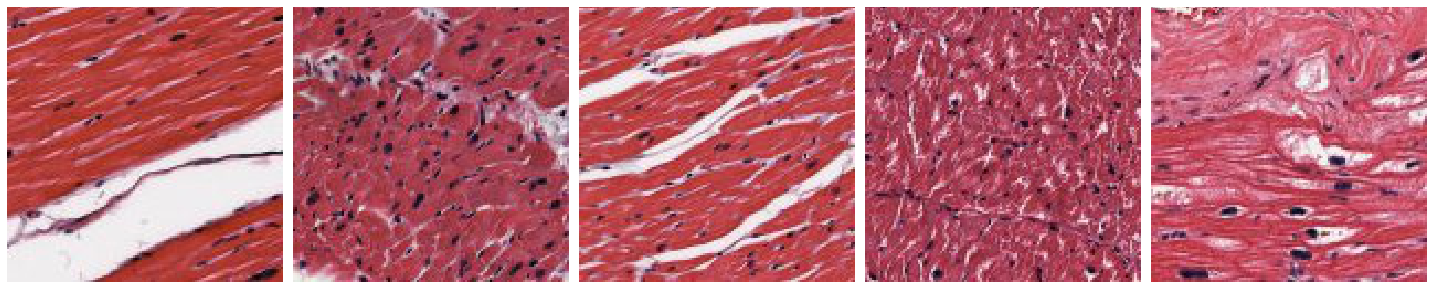

In [17]:
plotImages(sample_training_images[:5])

## Create the model

The model consists of three convolution blocks with a max pool layer in each of them. There's a fully connected layer with 512 units on top of it that is activated by a `relu` activation function.

In [18]:
model = Sequential([
#     V1
#     Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
#     MaxPooling2D(),
#     Conv2D(32, 3, padding='same', activation='relu'),
#     MaxPooling2D(),
#     Conv2D(64, 3, padding='same', activation='relu'),
#     MaxPooling2D(),
#     Flatten(),
#     Dense(512, activation='relu'),
#     Dense(1)
#     V2
#     Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
#     MaxPooling2D(),
#     Conv2D(32, 3, padding='same', activation='relu'),
#     Conv2D(64, 3, padding='same', activation='relu'),
#     MaxPooling2D(),
#     Conv2D(128, 3, padding='same', activation='relu'),
#     Conv2D(256, 3, padding='same', activation='relu'),
#     tf.keras.layers.BatchNormalization(),
#     MaxPooling2D(),
#     Flatten(),
#     Dense(512, activation='relu'),
#     Dense(1)
#     V3
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    Conv2D(128, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(256, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1)
])

### Compile the model

As all the other black magic in ML, the *ADAM* optimizer and *binary cross entropy* loss function are used here. To view training and validation accuracy for each training epoch, pass the `metrics` argument.

In [19]:
model.compile(
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.000004, amsgrad=False),    # or 0.000005
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Model summary

View all the layers of the network using the model's `summary` method:

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 125, 125, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 32)      4640      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 62, 62, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 62, 62, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 31, 31, 256)       2

### Train the model

Use the `fit_generator` method of the `ImageDataGenerator` class to train the network.

In [21]:
history = model.fit(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 24 steps, validate for 3 steps
Epoch 1/300
24/24 [==============================] - 367s 15s/step - loss: 0.6893 - accuracy: 0.5247 - val_loss: 0.6878 - val_accuracy: 0.5221
Epoch 2/300
24/24 [==============================] - 368s 15s/step - loss: 0.6866 - accuracy: 0.5239 - val_loss: 0.6832 - val_accuracy: 0.5221
Epoch 3/300
24/24 [==============================] - 372s 16s/step - loss: 0.6809 - accuracy: 0.5229 - val_loss: 0.6767 - val_accuracy: 0.5221
Epoch 4/300
24/24 [==============================] - 370s 15s/step - loss: 0.6722 - accuracy: 0.5240 - val_loss: 0.6694 - val_accuracy: 0.5221
Epoch 5/300
24/24 [==============================] - 361s 15s/step - loss: 0.6639 - accuracy: 0.5229 - val_loss: 0.6588 - val_accuracy: 0.5221
Epoch 6/300
24/24 [==============================] - 370s 15s/step - loss: 0.6538 - accuracy: 0.5244 - val_loss: 0.6490 - val_accuracy: 0.5234
Epoch 7/300
24/24 [==============================] 

24/24 [==============================] - 363s 15s/step - loss: 0.4925 - accuracy: 0.7421 - val_loss: 0.4843 - val_accuracy: 0.7461
Epoch 57/300
24/24 [==============================] - 368s 15s/step - loss: 0.4919 - accuracy: 0.7413 - val_loss: 0.4874 - val_accuracy: 0.7552
Epoch 58/300
24/24 [==============================] - 364s 15s/step - loss: 0.4906 - accuracy: 0.7477 - val_loss: 0.4816 - val_accuracy: 0.7435
Epoch 59/300
24/24 [==============================] - 368s 15s/step - loss: 0.4893 - accuracy: 0.7452 - val_loss: 0.4804 - val_accuracy: 0.7474
Epoch 60/300
24/24 [==============================] - 366s 15s/step - loss: 0.4875 - accuracy: 0.7482 - val_loss: 0.4814 - val_accuracy: 0.7409
Epoch 61/300
24/24 [==============================] - 370s 15s/step - loss: 0.4834 - accuracy: 0.7530 - val_loss: 0.4829 - val_accuracy: 0.7370
Epoch 62/300
24/24 [==============================] - 365s 15s/step - loss: 0.4834 - accuracy: 0.7485 - val_loss: 0.4835 - val_accuracy: 0.7370
Epoch

Epoch 113/300
24/24 [==============================] - 370s 15s/step - loss: 0.4440 - accuracy: 0.7819 - val_loss: 0.4423 - val_accuracy: 0.7878
Epoch 114/300
24/24 [==============================] - 368s 15s/step - loss: 0.4398 - accuracy: 0.7783 - val_loss: 0.4416 - val_accuracy: 0.7891
Epoch 115/300
24/24 [==============================] - 368s 15s/step - loss: 0.4371 - accuracy: 0.7824 - val_loss: 0.4435 - val_accuracy: 0.7891
Epoch 116/300
24/24 [==============================] - 366s 15s/step - loss: 0.4486 - accuracy: 0.7790 - val_loss: 0.4419 - val_accuracy: 0.7865
Epoch 117/300
24/24 [==============================] - 363s 15s/step - loss: 0.4416 - accuracy: 0.7775 - val_loss: 0.4401 - val_accuracy: 0.7930
Epoch 118/300
24/24 [==============================] - 362s 15s/step - loss: 0.4340 - accuracy: 0.7894 - val_loss: 0.4398 - val_accuracy: 0.7904
Epoch 119/300
24/24 [==============================] - 360s 15s/step - loss: 0.4374 - accuracy: 0.7847 - val_loss: 0.4383 - val_ac

24/24 [==============================] - 361s 15s/step - loss: 0.3949 - accuracy: 0.8141 - val_loss: 0.4154 - val_accuracy: 0.8034
Epoch 170/300
24/24 [==============================] - 362s 15s/step - loss: 0.3953 - accuracy: 0.8088 - val_loss: 0.4108 - val_accuracy: 0.8138
Epoch 171/300
24/24 [==============================] - 363s 15s/step - loss: 0.3987 - accuracy: 0.8080 - val_loss: 0.4177 - val_accuracy: 0.8073
Epoch 172/300
24/24 [==============================] - 366s 15s/step - loss: 0.3945 - accuracy: 0.8091 - val_loss: 0.4082 - val_accuracy: 0.8125
Epoch 173/300
24/24 [==============================] - 365s 15s/step - loss: 0.3967 - accuracy: 0.8116 - val_loss: 0.4084 - val_accuracy: 0.8138
Epoch 174/300
24/24 [==============================] - 365s 15s/step - loss: 0.3930 - accuracy: 0.8131 - val_loss: 0.4058 - val_accuracy: 0.8164
Epoch 175/300
24/24 [==============================] - 364s 15s/step - loss: 0.3921 - accuracy: 0.8090 - val_loss: 0.4047 - val_accuracy: 0.8112

24/24 [==============================] - 365s 15s/step - loss: 0.3547 - accuracy: 0.8327 - val_loss: 0.3759 - val_accuracy: 0.8346
Epoch 226/300
24/24 [==============================] - 361s 15s/step - loss: 0.3529 - accuracy: 0.8342 - val_loss: 0.3783 - val_accuracy: 0.8320
Epoch 227/300
24/24 [==============================] - 366s 15s/step - loss: 0.3576 - accuracy: 0.8356 - val_loss: 0.3939 - val_accuracy: 0.7982
Epoch 228/300
24/24 [==============================] - 359s 15s/step - loss: 0.3587 - accuracy: 0.8320 - val_loss: 0.3763 - val_accuracy: 0.8242
Epoch 229/300
24/24 [==============================] - 368s 15s/step - loss: 0.3495 - accuracy: 0.8389 - val_loss: 0.3755 - val_accuracy: 0.8359
Epoch 230/300
24/24 [==============================] - 369s 15s/step - loss: 0.3511 - accuracy: 0.8348 - val_loss: 0.3734 - val_accuracy: 0.8307
Epoch 231/300
24/24 [==============================] - 361s 15s/step - loss: 0.3499 - accuracy: 0.8381 - val_loss: 0.3818 - val_accuracy: 0.8164

24/24 [==============================] - 363s 15s/step - loss: 0.3176 - accuracy: 0.8561 - val_loss: 0.3544 - val_accuracy: 0.8464
Epoch 282/300
24/24 [==============================] - 362s 15s/step - loss: 0.3247 - accuracy: 0.8501 - val_loss: 0.3486 - val_accuracy: 0.8516
Epoch 283/300
24/24 [==============================] - 364s 15s/step - loss: 0.3210 - accuracy: 0.8539 - val_loss: 0.3480 - val_accuracy: 0.8490
Epoch 284/300
24/24 [==============================] - 366s 15s/step - loss: 0.3212 - accuracy: 0.8569 - val_loss: 0.3499 - val_accuracy: 0.8333
Epoch 285/300
24/24 [==============================] - 364s 15s/step - loss: 0.3304 - accuracy: 0.8458 - val_loss: 0.3478 - val_accuracy: 0.8346
Epoch 286/300
24/24 [==============================] - 365s 15s/step - loss: 0.3197 - accuracy: 0.8564 - val_loss: 0.3501 - val_accuracy: 0.8307
Epoch 287/300
24/24 [==============================] - 369s 15s/step - loss: 0.3176 - accuracy: 0.8544 - val_loss: 0.3556 - val_accuracy: 0.8190

### Visualize training results

Now visualize the results after training the network.

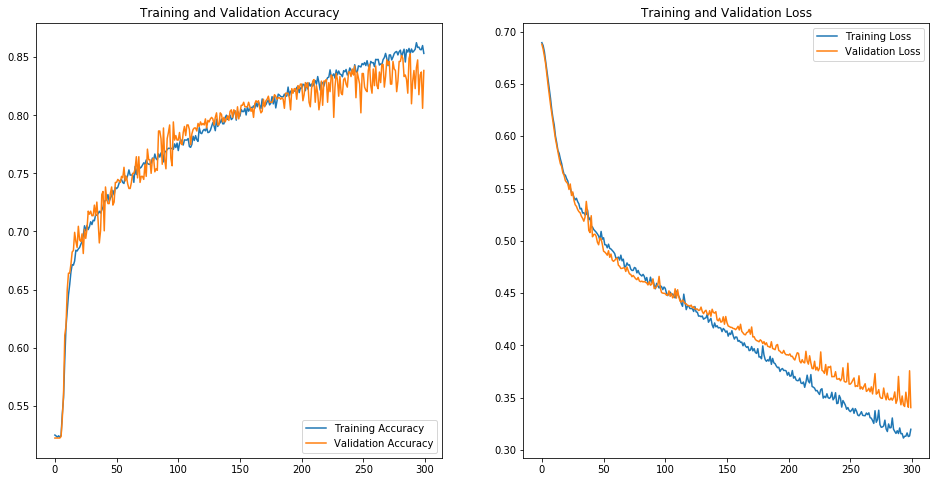

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

The training accuracy and validation accuracy are off by large margin and the model has achieved only around **75%** accuracy on the validation set while the training set is well on its way to **85%**. If given more epochs, the accuracy will diverge further. So does the loss.

## Overfitting

In the plots above, the training accuracy is increasing linearly over time, whereas validation accuracy stalls around 75% in the training process. Also, the difference in accuracy between training and validation accuracy is noticeable—a sign of *overfitting*.

When there are a small number of training examples, the model sometimes learns from noises or unwanted details from training examples—to an extent that it negatively impacts the performance of the model on new examples. This phenomenon is known as overfitting. It means that the model will have a difficult time generalizing on a new dataset.

There are multiple ways to fight overfitting in the training process. The *data augmentation* and *dropout* are popular techniques to overcome that.

## Data augmentation

Overfitting generally occurs when there are a small number of training examples. One way to fix this problem is to augment the dataset so that it has a sufficient number of training examples. Data augmentation takes the approach of generating more training data from existing training examples by augmenting them with random transformations that yield believable-looking images. The goal is the model will never see the exact same picture twice during training. This helps expose the model to more aspects of the data and generalize better.

Implement this in `tf.keras` using the `ImageDataGenerator` class. Pass  different transformations to the dataset and it will take care of applying it during the training process.

### Augment and visualize data

Begin by applying random horizontal flip augmentation to the dataset and see how individual images look like after the transformation.

### Apply horizontal flip

Pass `horizontal_flip` as an argument to the `ImageDataGenerator` class and set it to `True` to apply this augmentation.

In [23]:
# image_gen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)

In [24]:
# train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
#                                                directory=train_dir,
#                                                shuffle=True,
#                                                target_size=(IMG_HEIGHT, IMG_WIDTH))

Take one sample image from the training examples and repeat it five times so that the augmentation is applied to the same image five times.

In [25]:
# augmented_images = [train_data_gen[0][0][0] for i in range(5)]

In [26]:
# # Re-use the same custom plotting function defined and used
# # above to visualize the training images
# plotImages(augmented_images)

### Randomly rotate the image

Apply 45 degrees of rotation randomly to the training samples as another augmentation.

In [27]:
# image_gen = ImageDataGenerator(rescale=1./255, rotation_range=45)

In [28]:
# train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
#                                                directory=train_dir,
#                                                shuffle=True,
#                                                target_size=(IMG_HEIGHT, IMG_WIDTH))

# augmented_images = [train_data_gen[0][0][0] for i in range(5)]

In [29]:
# plotImages(augmented_images)

### Apply zoom augmentation

Apply a zoom augmentation to the dataset to zoom images up to 50% randomly.

In [30]:
# # zoom_range from 0 - 1 where 1 = 100%.
# image_gen = ImageDataGenerator(rescale=1./255, zoom_range=0.5) # 

In [31]:
# train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
#                                                directory=train_dir,
#                                                shuffle=True,
#                                                target_size=(IMG_HEIGHT, IMG_WIDTH))

# augmented_images = [train_data_gen[0][0][0] for i in range(5)]

In [32]:
# plotImages(augmented_images)

### Put it all together

Apply all the previous augmentations: rescale, 45 degree rotation, width shift, height shift, horizontal flip and zoom augmentation to the training images.

In [33]:
# image_gen_train = ImageDataGenerator(
#                     rescale=1./255,
#                     rotation_range=45,
#                     width_shift_range=.15,
#                     height_shift_range=.15,
#                     horizontal_flip=True,
#                     zoom_range=0.5
#                     )

In [34]:
# train_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
#                                                      directory=train_dir,
#                                                      shuffle=True,
#                                                      target_size=(IMG_HEIGHT, IMG_WIDTH),
#                                                      class_mode='binary')

Visualize how a single image would look five different times when passing these augmentations randomly to the dataset.

In [35]:
# augmented_images = [train_data_gen[0][0][0] for i in range(5)]
# plotImages(augmented_images)

### Create validation data generator

Generally, only apply data augmentation to the training examples. In this case, only rescale the validation images and convert them into batches using `ImageDataGenerator`.

In [36]:
# image_gen_val = ImageDataGenerator(rescale=1./255)

In [37]:
# val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
#                                                  directory=validation_dir,
#                                                  target_size=(IMG_HEIGHT, IMG_WIDTH),
#                                                  class_mode='binary')

## Dropout

Another technique to reduce overfitting is to introduce *dropout* to the network. It is a form of *regularization* that forces the weights in the network to take only small values, which makes the distribution of weight values more regular and the network can reduce overfitting on small training examples. Dropout is one of the regularization technique used in multiple ML scenarios, including image classification.

When you apply dropout to a layer it randomly drops out (set to zero) number of output units from the applied layer during the training process. Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.

When appling 0.1 dropout to a certain layer, it randomly kills 10% of the output units in each training epoch.

Create a network architecture with this new dropout feature and apply it to different convolutions and fully-connected layers.

## Creating a new network with Dropouts

Apply dropout to first and last max pool layers. Applying dropout will randomly set 20% of the neurons to zero during each training epoch. This helps to avoid overfitting on the training dataset. And of course, it could also forget useful knowledge.

In [38]:
# model_new = Sequential([
# #     V1
# #     Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
# #     MaxPooling2D(),
# #     Dropout(0.2),
# #     Conv2D(32, 3, padding='same', activation='relu'),
# #     MaxPooling2D(),
# #     Conv2D(64, 3, padding='same', activation='relu'),
# #     MaxPooling2D(),
# #     Dropout(0.2),
# #     Flatten(),
# #     Dense(512, activation='relu'),
# #     Dense(1)
# #     V2
# #     Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
# #     MaxPooling2D(),
# #     Conv2D(32, 3, padding='same', activation='relu'),
# #     Conv2D(64, 3, padding='same', activation='relu'),
# #     MaxPooling2D(),
# #     Conv2D(128, 3, padding='same', activation='relu'),
# #     Conv2D(256, 3, padding='same', activation='relu'),
# #     tf.keras.layers.BatchNormalization(),
# #     MaxPooling2D(),
# #     Flatten(),
# #     Dense(512, activation='relu'),
# #     Dense(1)
# #     V3
#     Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
#     Conv2D(32, 3, padding='same', activation='relu'),
#     MaxPooling2D(),
#     Dropout(0.2),
#     Conv2D(64, 3, padding='same', activation='relu'),
#     Conv2D(128, 3, padding='same', activation='relu'),
#     MaxPooling2D(),
#     Conv2D(256, 3, padding='same', activation='relu'),
#     MaxPooling2D(),
#     Dropout(0.2),
#     Flatten(),
#     Dense(512, activation='relu'),
#     Dense(1)
# ])

### Compile the model

After introducing dropouts to the network, compile the model and view the layers summary.

In [39]:
# model_new.compile(
#                   optimizer=tf.keras.optimizers.Adam(learning_rate=0.00035, amsgrad=False),     # or 0.00035
#                   loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
#                   metrics=['accuracy'])

# model_new.summary()

### Train the model

After successfully introducing data augmentations to the training examples and adding dropouts to the network, train this new network:

In [40]:
# history = model_new.fit(
#     train_data_gen,
#     steps_per_epoch=total_train // batch_size,
#     epochs=epochs,
#     validation_data=val_data_gen,
#     validation_steps=total_val // batch_size
# )

### Visualize the model

Visualize the new model after training. There is significantly less overfitting than before. The accuracy suffers slightly. However, there is no divergence in either accuracy or loss in training and verification data sets.

In [41]:
# acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']

# loss = history.history['loss']
# val_loss = history.history['val_loss']

# epochs_range = range(epochs)

# plt.figure(figsize=(16, 8))
# plt.subplot(1, 2, 1)
# plt.plot(epochs_range, acc, label='Training Accuracy')
# plt.plot(epochs_range, val_acc, label='Validation Accuracy')
# plt.legend(loc='lower right')
# plt.title('Training and Validation Accuracy')

# plt.subplot(1, 2, 2)
# plt.plot(epochs_range, loss, label='Training Loss')
# plt.plot(epochs_range, val_loss, label='Validation Loss')
# plt.legend(loc='upper right')
# plt.title('Training and Validation Loss')
# plt.show()